# Centralizing the Data Vizualizations from the Paper

In [169]:
# dependencies
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model

import emission.core.get_database as edb
from plots import *
import scaffolding

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [152]:
# loading the data
data = pd.read_csv("filtered_merged_trips.csv")

/tmp/ipykernel_71/3633409825.py:2: DtypeWarning: Columns (65,72,75) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("filtered_merged_trips.csv")


In [153]:
# Summary statistics table #MOVE TO ANALYSIS NOTEBOOK
mode_of_interest = 'E-bike'
data_eb = data.query(f"mode_confirm == '{mode_of_interest}'")
print(len(pd.unique(data.user_id)))
stat_data = data[['distance_miles','duration']]
stat_data.describe()

122


,distance_miles,duration
count,61496.000000,61496.000000
mean,3.933690,24.145146
std,5.991457,30.691071
min,0.062013,0.000068
25%,0.721590,9.173613
50%,1.983511,15.289998
75%,4.342240,28.071609
max,49.929320,479.495935


## Modes in Mini vs Full Pilot

In [154]:
# processing mini data
mini_data = pd.read_csv("trip_program.csv")
mini_data = mini_data[mini_data.program == 'prepilot']
MINI_DATA = mini_data.copy() #saving a copy for later

# Combine variable categories
mini_data = mini_data.replace('Gas Car, drove alone', 'Car')
mini_data = mini_data.replace('Gas Car, with others', 'Shared Car')
mini_data = mini_data.replace('Bikeshare', 'Shared Micromobility')
mini_data = mini_data.replace('Scooter share', 'Shared Micromobility')
mini_data = mini_data.replace('Regular Bike', 'Personal Micromobility')
mini_data = mini_data.replace('Skate board', 'Personal Micromobility')
mini_data = mini_data.replace('Train', 'Transit')
mini_data = mini_data.replace('Free Shuttle', 'Transit')
mini_data = mini_data.replace('Bus', 'Transit')
mini_data = mini_data.replace('Walk', 'Walk')
mini_data = mini_data.replace('Taxi/Uber/Lyft', 'Ridehail')
mini_data = mini_data.replace('Pilot ebike', 'E-Bike')

#filter out 'not a trip' trips
mini_data = mini_data[~mini_data['Mode_confirm'].isin(['Not a Trip'])]
mini_data = mini_data[~mini_data['Replaced_mode'].isin(['Not a Trip'])]
mini_data = mini_data[~mini_data['Trip_purpose'].isin(['not_a_trip'])]

In [155]:
mini_data.loc[mini_data['Mode_confirm']=='Personal Micromobility', 'Mode_confirm'] = 'Other'
mini_data.loc[mini_data['Mode_confirm']=='Shared Micromobility', 'Mode_confirm'] = 'Other'

t1 = mini_data.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
t1['proportion'] = t1['distance_miles'] / np.sum(t1.distance_miles)
t1['trip_type'] = 'All Trips'

t2 = mini_data[mini_data['Trip_purpose']=='Work'].copy()
t2 = t2.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
t2['proportion'] = t2['distance_miles'] / np.sum(t2.distance_miles)
t2['trip_type'] = 'Work Trips'
t2.loc[1.5] = 'Other', 0, 0, 'Work Trips'
t2 = t2.sort_index().reset_index(drop=True)

mini_data = pd.concat([t1,t2])
mini_data['Dataset'] = 'Minipilot'
mini_data.columns = ['Mode','Count','Proportion','Trip Type', "Dataset"]

# processing long data
plot_data = data.copy()
plot_data.loc[plot_data['Mode_confirm']=='Personal Micromobility', 'Mode_confirm'] = 'Other'
plot_data.loc[plot_data['Mode_confirm']=='Shared Micromobility', 'Mode_confirm'] = 'Other'

t1 = plot_data.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
t1['proportion'] = t1['distance_miles'] / np.sum(t1.distance_miles)
t1['trip_type'] = 'All Trips'

t2 = plot_data[plot_data['Trip_purpose']=='Work'].copy()
t2 = t2.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
t2['proportion'] = t2['distance_miles'] / np.sum(t2.distance_miles)
t2['trip_type'] = 'Work Trips'

plot_data = pd.concat([t1,t2])
plot_data['Dataset'] = 'Long Term'
plot_data.columns = ['Mode','Count','Proportion','Trip Type', "Dataset"]

plot_data = pd.concat([plot_data, mini_data])
plot_data

,Mode,Count,Proportion,Trip Type,Dataset
0,Car,15763,0.256326,All Trips,Long Term
1,E-bike,17348,0.282100,All Trips,Long Term
2,Other,2127,0.034588,All Trips,Long Term
3,Ridehail,324,0.005269,All Trips,Long Term
4,Shared Car,14680,0.238715,All Trips,Long Term
5,Transit,1396,0.022701,All Trips,Long Term
6,Walk,9858,0.160303,All Trips,Long Term
0,Car,3758,0.282939,Work Trips,Long Term
1,E-bike,5959,0.448652,Work Trips,Long Term
2,Other,339,0.025523,Work Trips,Long Term


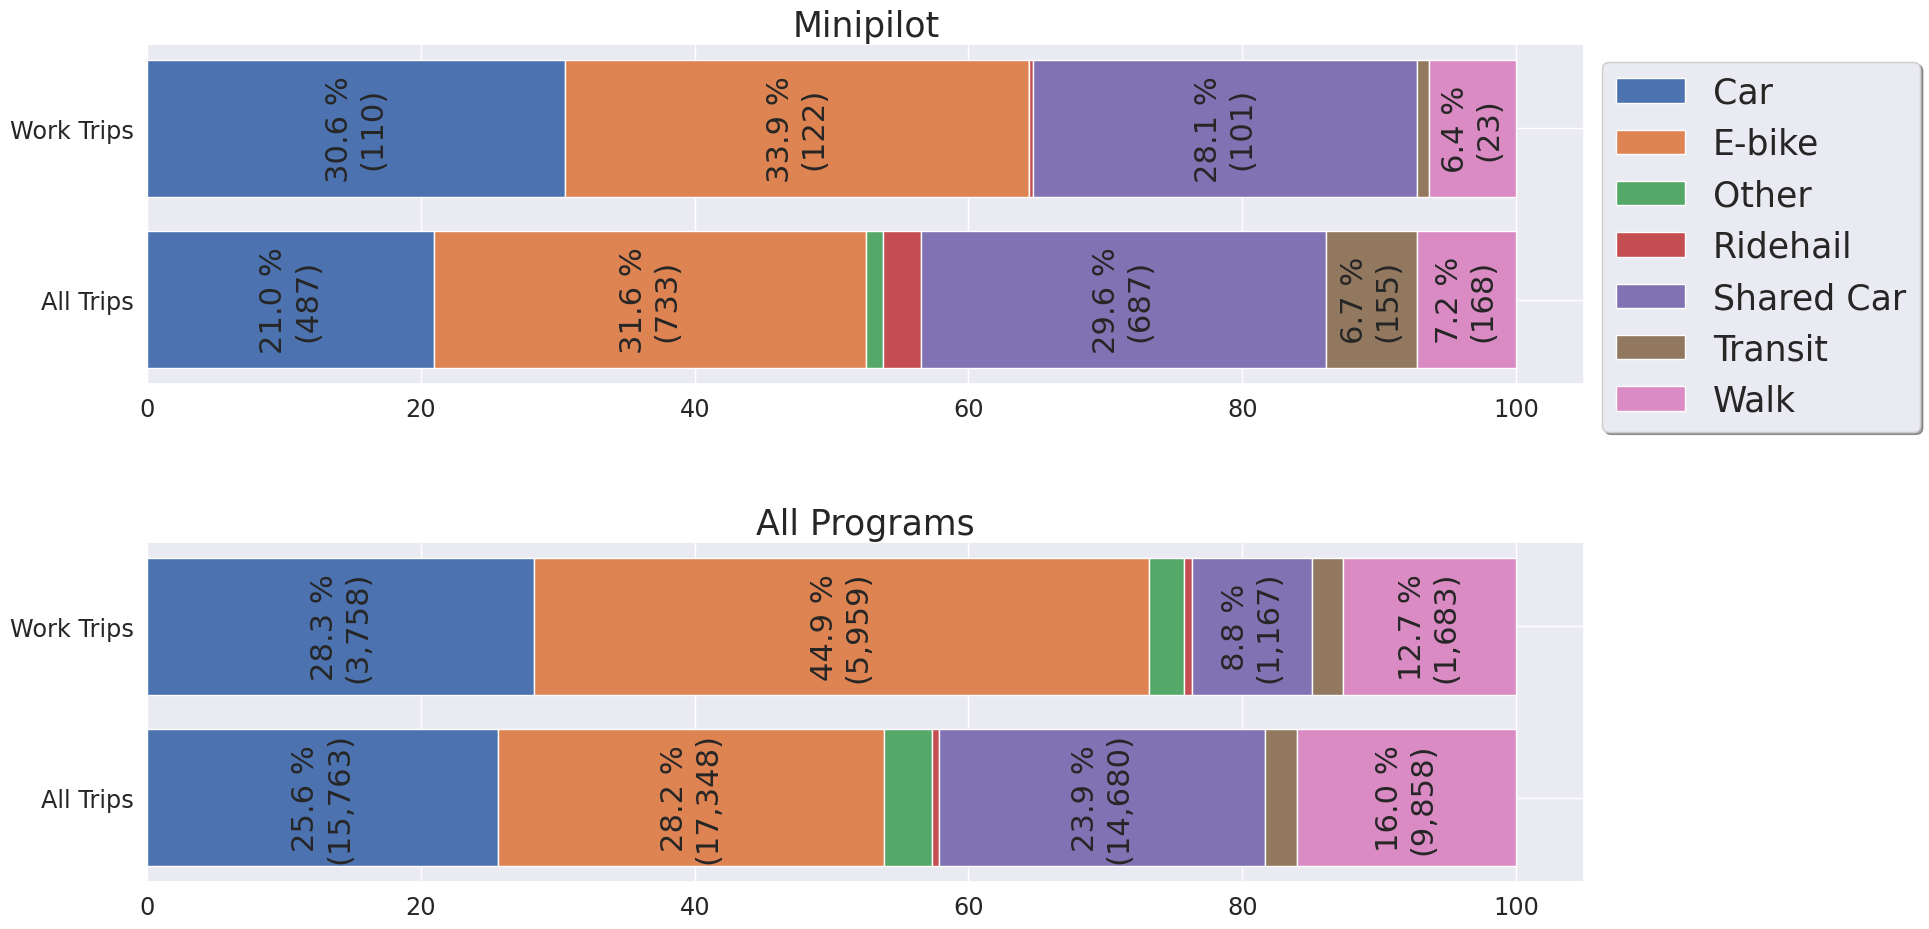

In [170]:
# make and save the chart

width = 0.8
fig, ax = plt.subplots(2,1, figsize=(20,10))
plt.rcParams.update({'font.size': 30}) 
running_total_mini = [0,0]
running_total_long = [0,0]
fig_data_mini = plot_data[plot_data['Dataset']=='Minipilot']
fig_data_long = plot_data[plot_data['Dataset']=='Long Term']

for mode in pd.unique(fig_data_mini.Mode):
    mini = fig_data_mini[fig_data_mini['Mode']==mode]
    long = fig_data_long[fig_data_long['Mode']==mode]
    
    labels = mini['Trip Type']
    vals = mini['Proportion']*100
    bar_labels = mini['Count']
    vals_str = [f'{y:.1f} %\n({x:,})' if y>5 else '' for x, y in zip(bar_labels, vals)]
    bar = ax[0].barh(labels, vals, width, left=running_total_mini, label=mode)
    ax[0].bar_label(bar, label_type='center', labels=vals_str, rotation=90, fontsize=22)
    running_total_mini[0] = running_total_mini[0]+vals.iloc[0]
    running_total_mini[1] = running_total_mini[1]+vals.iloc[1]

    labels = long['Trip Type']
    vals = long['Proportion']*100
    bar_labels = long['Count']
    vals_str = [f'{y:.1f} %\n({x:,})' if y>5 else '' for x, y in zip(bar_labels, vals)]
    bar = ax[1].barh(labels, vals, width, left=running_total_long, label=mode)
    ax[1].bar_label(bar, label_type='center', labels=vals_str, rotation=90, fontsize=22)
    running_total_long[0] = running_total_long[0]+vals.iloc[0]
    running_total_long[1] = running_total_long[1]+vals.iloc[1]

ax[0].set_title('Minipilot', fontsize=25)
ax[1].set_title('All Programs', fontsize=25)
ax[0].legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True, fontsize=25)
plt.subplots_adjust(bottom=0.20)
fig.tight_layout()
plt.show()

## Mode Share by Program

In [108]:
# process the data for the clustered chart
data.program.unique()

array(['4c', 'cc', 'fc', 'pc', 'sc', 'vail'], dtype=object)

In [109]:
mode_data = data.copy()

#clean up the modes
mode_data.loc[mode_data['Mode_confirm']=='Personal Micromobility', 'Mode_confirm'] = 'Other'
mode_data.loc[mode_data['Mode_confirm']=='Shared Micromobility', 'Mode_confirm'] = 'Other'

program_list = ['4c', 'cc', 'fc', 'pc', 'sc', 'vail']
work_plot_data = []
all_plot_data = []
for program in program_list:
    program_data = mode_data[mode_data.program == program]

    t1 = program_data.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
    t1[program] = (t1['distance_miles'] / np.sum(t1.distance_miles)) * 100
    t1 = t1.set_index('Mode_confirm')
    t1 = t1.drop(columns = ['distance_miles'])
    all_plot_data.append(t1)

    t2 = program_data[program_data['Trip_purpose']=='Work'].copy()
    t2 = t2.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
    t2[program] = (t2['distance_miles'] / np.sum(t2.distance_miles)) * 100
    t2 = t2.set_index('Mode_confirm')
    t2 = t2.drop(columns = ['distance_miles'])
    work_plot_data.append(t2)
    
work_trips = pd.concat(work_plot_data, axis = 1)
all_trips = pd.concat(all_plot_data, axis = 1)

all_trips = all_trips.transpose()
work_trips = work_trips.transpose()

In [110]:
# make and save the clustered chart

In [111]:
#from https://stackoverflow.com/questions/22787209/how-to-have-clusters-of-stacked-bars
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe

<Axes: title={'center': 'Mode Share by Program'}>

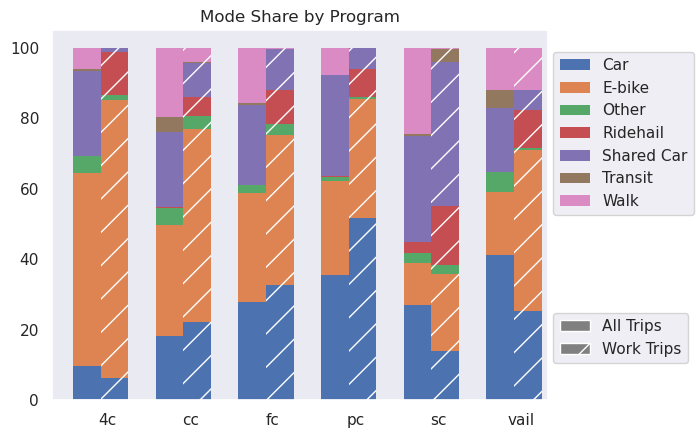

In [112]:
# Then, just call :
plot_clustered_stacked([all_trips, work_trips],["All Trips", "Work Trips"], title = "Mode Share by Program")

## Trip Purpose Mini vs Full

In [138]:
#arrange the data
full_purpose_data = data.copy()
mini_purpose_data = MINI_DATA.copy()

#MINI DATA
mini_data = mini_purpose_data.copy()
mini_data = mini_data[~mini_data['Trip_purpose'].isin(['No travel'])]
mini_data.loc[mini_data['Trip_purpose']=='Religious', 'Trip_purpose'] = 'Other'
mini_data.loc[mini_data['Trip_purpose']=='School', 'Trip_purpose'] = 'Other'

t1 = mini_data.groupby(['Trip_purpose'], as_index=False).count()[['Trip_purpose','distance_miles']]
t1['proportion'] = t1['distance_miles'] / np.sum(t1.distance_miles)
t1['trip type'] = 'All Trips'

t2 = mini_data[mini_data['Mode_confirm']=='E-bike'].copy()
t2 = t2.groupby(['Trip_purpose'], as_index=False).count()[['Trip_purpose','distance_miles']]
t2['proportion'] = t2['distance_miles'] / np.sum(t2.distance_miles)
t2['trip type'] = 'E-Bike Trips'

mini_data = pd.concat([t1,t2])
mini_data['Dataset'] = 'Minipilot'
mini_data.columns = ['Purpose','Count','Proportion','Trip Type', "Dataset"]

#FULL DATA
plot_data = full_purpose_data.copy()
plot_data.loc[plot_data['Trip_purpose']=='Religious', 'Trip_purpose'] = 'Other'
plot_data.loc[plot_data['Trip_purpose']=='School', 'Trip_purpose'] = 'Other'
t1 = plot_data.groupby(['Trip_purpose'], as_index=False).count()[['Trip_purpose','distance_miles']]
t1['proportion'] = t1['distance_miles'] / np.sum(t1.distance_miles)
t1['trip type'] = 'All Trips'
t1.loc[len(t1.index)] = ['Pick-up/Drop off', 0, 0, 'All Trips']

t2 = plot_data[plot_data['Mode_confirm']=='E-bike'].copy()
t2 = t2.groupby(['Trip_purpose'], as_index=False).count()[['Trip_purpose','distance_miles']]
t2['proportion'] = t2['distance_miles'] / np.sum(t2.distance_miles)
t2['trip type'] = 'E-Bike Trips'
t2.loc[len(t2.index)] = ['Pick-up/Drop off', 0, 0, 'E-Bike Trips']

plot_data = pd.concat([t1,t2])
plot_data['Dataset'] = 'Long Term'
plot_data.columns = ['Purpose','Count','Proportion','Trip Type', "Dataset"]

plot_data = pd.concat([plot_data, mini_data])
# plot_data

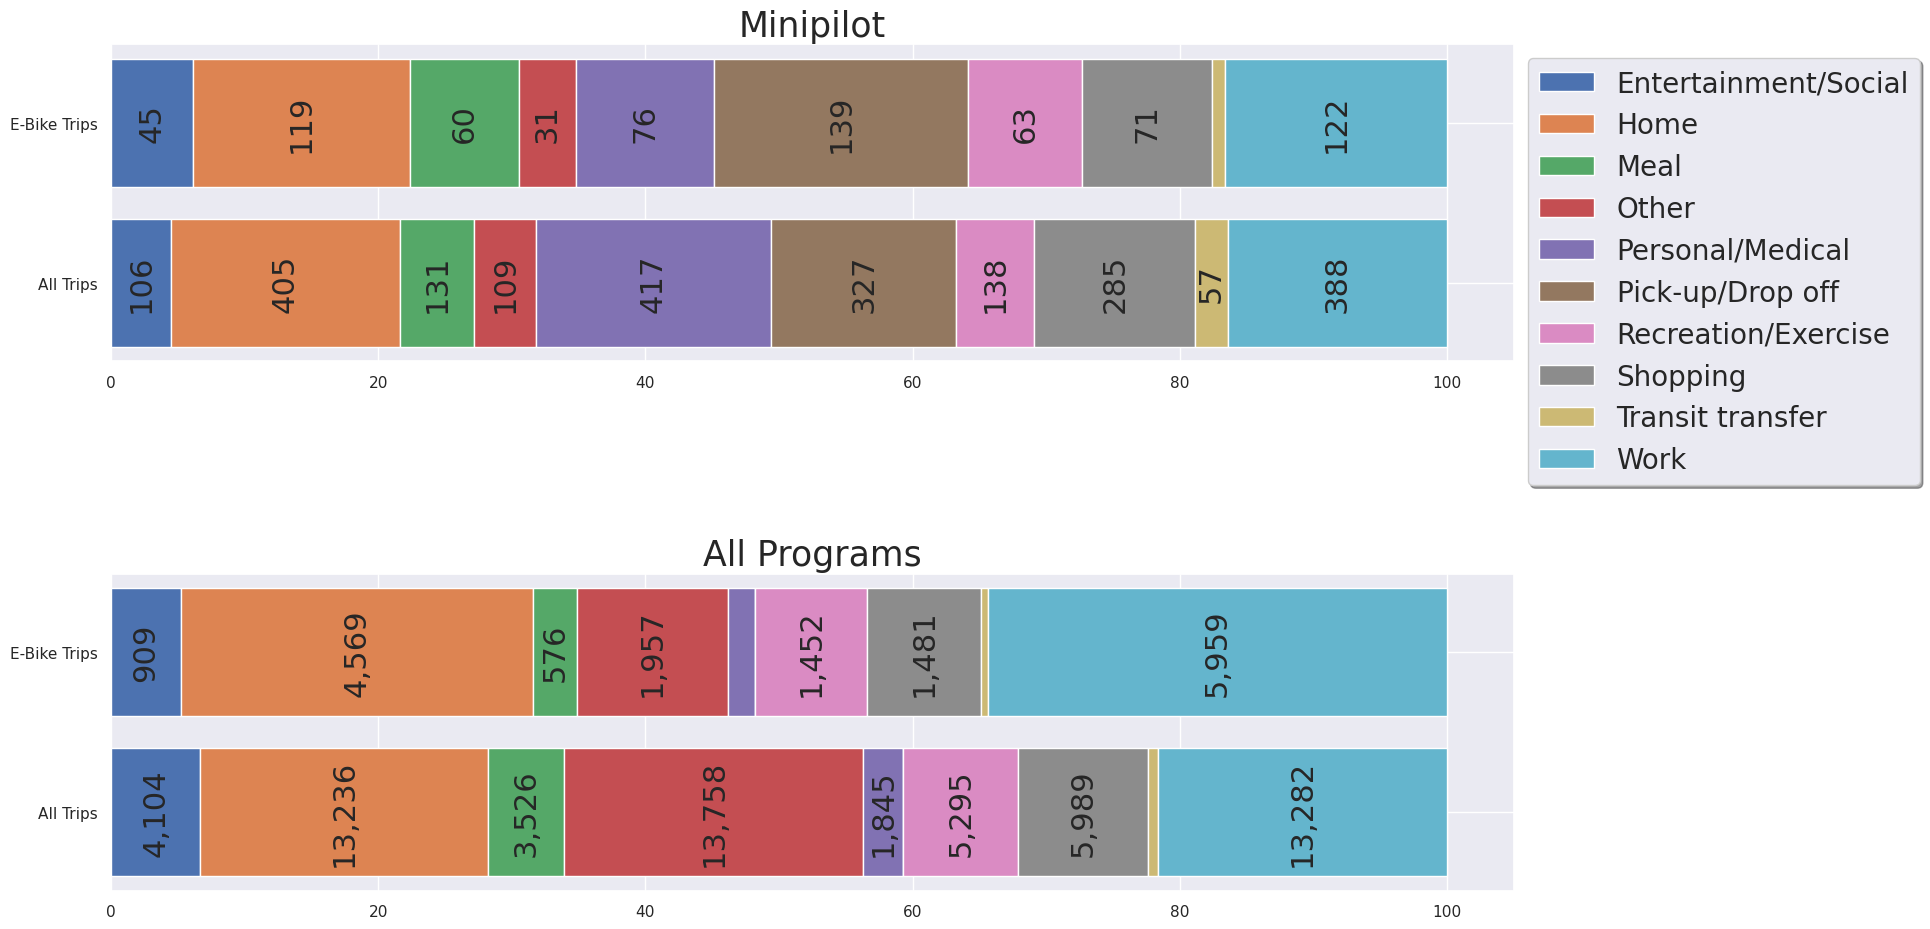

In [137]:
# create the chart

width = 0.8
fig, ax = plt.subplots(2,1, figsize=(20,10))
plt.rcParams.update({'font.size': 30}) 
running_total_mini = [0,0]
running_total_long = [0,0]
fig_data_mini = plot_data[plot_data['Dataset']=='Minipilot']
fig_data_long = plot_data[plot_data['Dataset']=='Long Term']

for purp in pd.unique(fig_data_mini.Purpose):
    mini = fig_data_mini[fig_data_mini['Purpose']==purp]
    long = fig_data_long[fig_data_long['Purpose']==purp]
    
    labels = mini['Trip Type']
    vals = mini['Proportion']*100
    bar_labels = mini['Count']
    vals_str = [x if x>30 else '' for x in bar_labels]
    bar = ax[0].barh(labels, vals, width, left=running_total_mini, label=purp)
    ax[0].bar_label(bar, label_type='center', labels=vals_str, rotation=90, fontsize=22)
    running_total_mini[0] = running_total_mini[0]+vals.iloc[0]
    running_total_mini[1] = running_total_mini[1]+vals.iloc[1]

    labels = long['Trip Type']
    vals = long['Proportion']*100
    bar_labels = long['Count']
    vals_str = [f'{x:,}' if x>500 else '' for x in bar_labels]
    bar = ax[1].barh(labels, vals, width, left=running_total_long, label=purp)
    ax[1].bar_label(bar, label_type='center', labels=vals_str, rotation=90, fontsize=22)
    running_total_long[0] = running_total_long[0]+vals.iloc[0]
    running_total_long[1] = running_total_long[1]+vals.iloc[1]

ax[0].set_title('Minipilot', fontsize=25)
ax[1].set_title('All Programs', fontsize=25)
ax[0].legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True, fontsize=20)
plt.subplots_adjust(bottom=0.20)
fig.tight_layout()
plt.show()

In [140]:
#clean up the modes

full_purpose_data = data.copy()
e_purpose = full_purpose_data[full_purpose_data.Mode_confirm == 'E-bike']

e_purpose.loc[e_purpose['Trip_purpose']=='Religious', 'Trip_purpose'] = 'Other'
e_purpose.loc[e_purpose['Trip_purpose']=='School', 'Trip_purpose'] = 'Other'

# t1 = plot_data.groupby(['Trip_purpose'], as_index=False).count()[['Trip_purpose','distance_miles']]
# t1['proportion'] = t1['distance_miles'] / np.sum(t1.distance_miles)
# t1['trip type'] = 'All Trips'
# t1.loc[len(t1.index)] = ['Pick-up/Drop off', 0, 0, 'All Trips']

program_list = ['4c', 'cc', 'fc', 'pc', 'sc', 'vail']
all_plot_data = []
for program in program_list:
    program_data = mode_data[mode_data.program == program]

    t1 = program_data.groupby(['Trip_purpose'], as_index=False).count()[['Trip_purpose','distance_miles']]
    t1[program] = (t1['distance_miles'] / np.sum(t1.distance_miles)) * 100
    t1 = t1.set_index('Trip_purpose')
    t1 = t1.drop(columns = ['distance_miles'])
    all_plot_data.append(t1)
    
all_trips = pd.concat(all_plot_data, axis = 1)

all_trips = all_trips.transpose()


Trip_purpose,Entertainment/Social,Home,Meal,Other,Personal/Medical,Recreation/Exercise,Religious,School,Shopping,Transit transfer,Work
4c,5.223214,25.714286,6.250000,11.607143,1.651786,11.250000,0.044643,1.383929,12.544643,0.669643,23.660714
cc,8.834639,21.458391,7.522564,16.456602,2.202696,9.761043,0.548686,2.174864,9.061270,1.288219,20.691026
fc,4.194820,22.344219,3.537913,19.378754,2.862237,7.160285,0.375375,2.496246,9.290541,0.365991,27.993619
pc,6.236133,19.730586,5.340729,25.309033,5.887480,7.266244,0.412044,0.839937,9.865293,0.277338,18.835182
sc,5.280123,25.019186,4.466616,12.586339,2.317728,9.746738,1.765157,0.046048,13.737529,0.184190,24.850345
vail,4.334724,17.663421,3.523412,45.757997,1.274919,6.328234,0.139082,0.023180,6.930923,0.834492,13.189615


<Axes: title={'center': 'E-bike Purpose Share by Program'}>

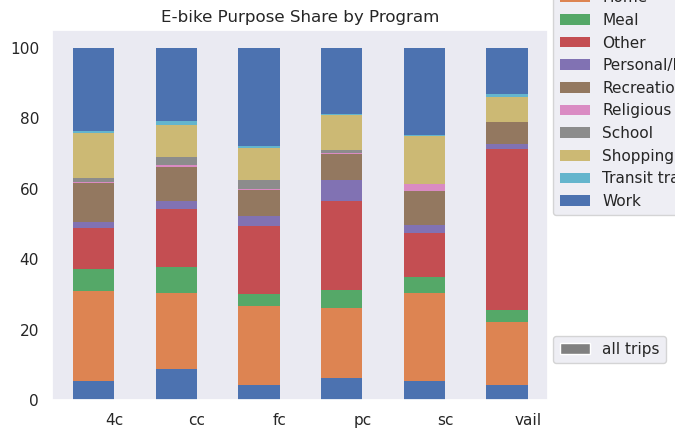

In [142]:
plot_clustered_stacked([all_trips], ["all trips"], title = "E-bike Purpose Share by Program")

In [147]:
# What purpose ebike is used for by program
plot_data = data.copy()
#plot_data['month'] = plot_data.date_time.dt.month
#plot_data['month'] = plot_data['month'].replace([6,7,8,9,10,11,12,1,2,3,4,5], ['Summer','Summer','Summer','Fall','Fall','Fall','Winter','Winter','Winter','Spring','Spring','Spring'])
t1 = plot_data.groupby(['program','Trip_purpose','Mode_confirm'], as_index=False).sum()[['program','Trip_purpose','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t1

/tmp/ipykernel_71/3359380240.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t1 = plot_data.groupby(['program','Trip_purpose','Mode_confirm'], as_index=False).sum()[['program','Trip_purpose','Mode_confirm','distance_miles']]


,program,Trip_purpose,Mode_confirm,distance_miles
0,4c,Entertainment/Social,Car,35.470583
1,4c,Entertainment/Social,E-bike,93.175102
2,4c,Entertainment/Social,Other,6.772128
3,4c,Entertainment/Social,Personal Micromobility,16.599800
4,4c,Entertainment/Social,Shared Car,441.043486
...,...,...,...,...
431,vail,Work,Other,2.672662
432,vail,Work,Shared Car,312.275339
433,vail,Work,Shared Micromobility,14.764434
434,vail,Work,Transit,215.915592


In [148]:
t2 = plot_data.groupby(['program','Trip_purpose'], as_index=False).sum()[['program','Trip_purpose','distance_miles']]
t2

/tmp/ipykernel_71/4059493393.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t2 = plot_data.groupby(['program','Trip_purpose'], as_index=False).sum()[['program','Trip_purpose','distance_miles']]


,program,Trip_purpose,distance_miles
0,4c,Entertainment/Social,620.664656
1,4c,Home,2542.216961
2,4c,Meal,451.725764
3,4c,Other,1698.685597
4,4c,Personal/Medical,206.549862
...,...,...,...
61,vail,Religious,56.634564
62,vail,School,22.351089
63,vail,Shopping,2070.813055
64,vail,Transit transfer,130.223340


In [149]:
plot_data = t1.merge(t2, on=['program','Trip_purpose'])
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y'] #where x is e-bike miles and y is total miles for purpose
plot_data['proportion'].fillna(0, inplace=True)
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data

#plot_data['Program'] = plot_data['program'].replace(['4c','cc','fc','pc','sc','vail'],['Four Corners','Community Cycles (Boulder)','Fort Collins','Pueblo County','Smart Commute (Northridge)','Vail'])

,program,Trip_purpose,Mode_confirm,distance_miles_x,distance_miles_y,proportion
1,4c,Entertainment/Social,E-bike,93.175102,620.664656,0.150121
8,4c,Home,E-bike,935.286390,2542.216961,0.367902
16,4c,Meal,E-bike,120.780485,451.725764,0.267376
22,4c,Other,E-bike,214.625609,1698.685597,0.126348
30,4c,Personal/Medical,E-bike,6.594606,206.549862,0.031927
...,...,...,...,...,...,...
406,vail,Recreation/Exercise,E-bike,106.625897,1288.233732,0.082769
412,vail,Religious,E-bike,11.179911,56.634564,0.197404
416,vail,Shopping,E-bike,128.614070,2070.813055,0.062108
423,vail,Transit transfer,E-bike,10.243900,130.223340,0.078664
